In [ ]:
import tensorflow as tf
# import pandas as pd
import os
import numpy as np
import random
# import cv2
import matplotlib.pyplot as plt
# from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.metrics import classification_report,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/MyDrive/dataset botol 2"

In [ ]:
train_dir = "/content/drive/MyDrive/dataset_split3/train"
test_dir = "/content/drive/MyDrive/dataset_split3/test"
val_dir = "/content/drive/MyDrive/dataset_split3/val"

In [ ]:
# Data augmentation untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation untuk validasi dan pengujian
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1294 images belonging to 4 classes.
Found 680 images belonging to 4 classes.
Found 441 images belonging to 4 classes.


In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze sebagian besar layer
for layer in base_model.layers[:-10]:  # Fine-tune hanya 10 lapisan terakhir
    layer.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Jumlah kelas otomatis

# Menggabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8814 - loss: 0.2940 - val_accuracy: 0.8338 - val_loss: 0.6154 - learning_rate: 2.0000e-05
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 0.8682 - loss: 0.3233 - val_accuracy: 0.8294 - val_loss: 0.5694 - learning_rate: 2.0000e-05
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.9060 - loss: 0.2848 - val_accuracy: 0.8412 - val_loss: 0.5677 - learning_rate: 2.0000e-05
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.9110 - loss: 0.2369 - val_accuracy: 0.8147 - val_loss: 0.6719 - learning_rate: 2.0000e-05
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.8913 - loss: 0.2834 - val_accuracy: 0.8412 - val_loss: 0.5252 - learning_rate: 2.0000e-05
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - accuracy: 0.8978 - loss: 0.2483 - val_accuracy: 0.8412 - val_loss: 0.5077 - learning_rate: 2.0000e-05
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - accuracy: 0.9246 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8644 - loss: 0.4383
Test Loss: 0.33890342712402344
Test Accuracy: 0.8822115659713745


In [ ]:
#Save model
model.save('/content/drive/MyDrive/dataset_split3/recycle_model1.h5')

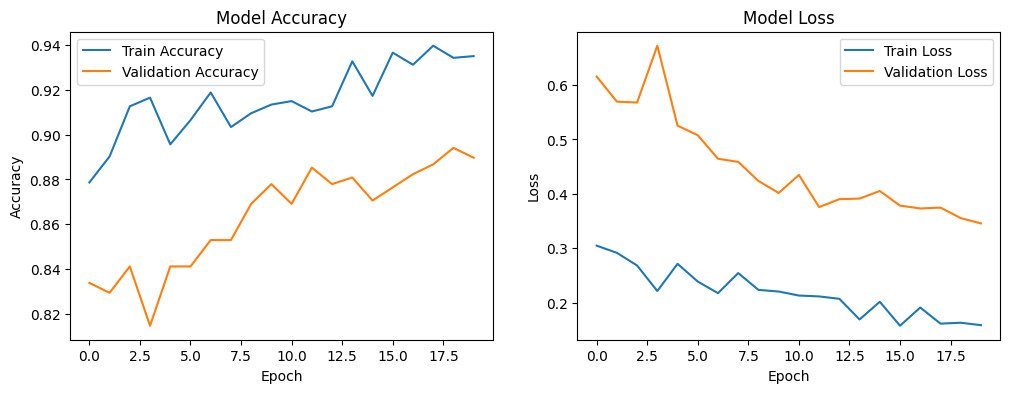

In [ ]:
# Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


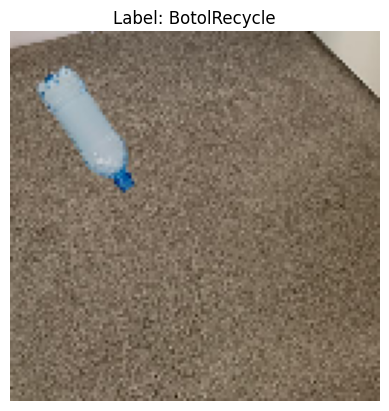

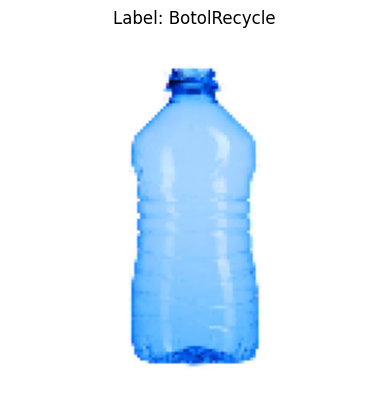

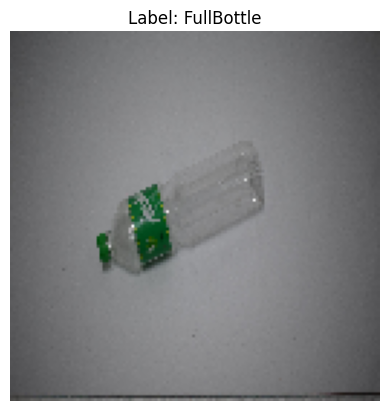

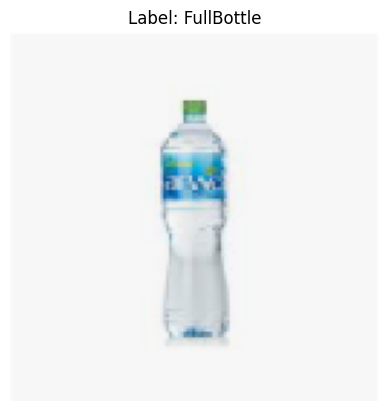

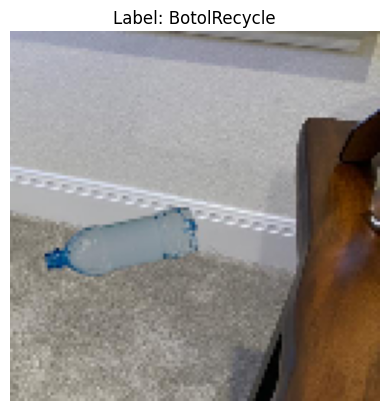

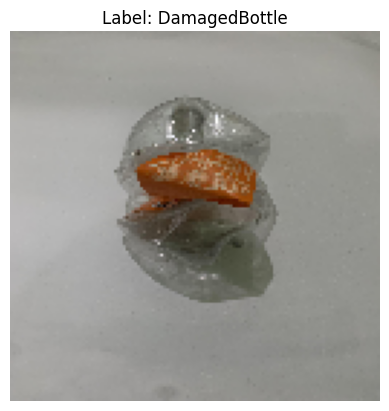

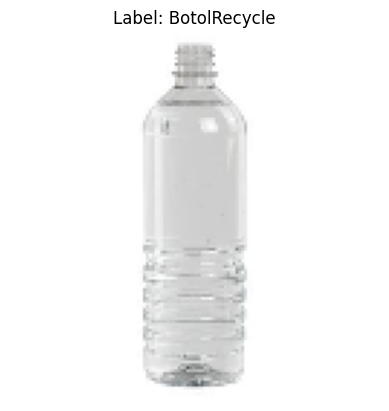

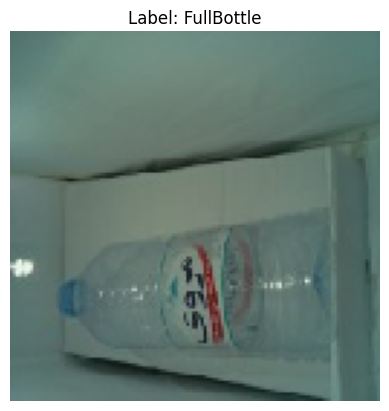

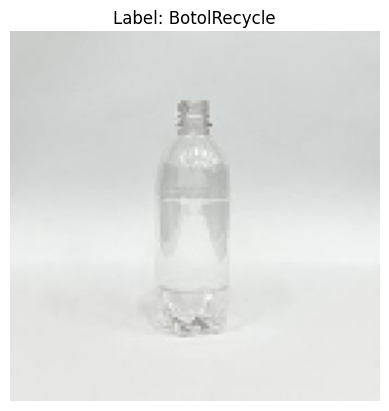

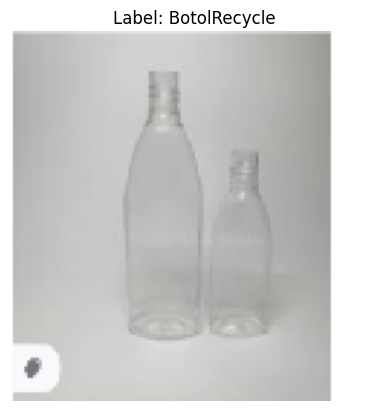

In [ ]:
# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(128, 128))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(10):
    load_and_display_random_image_with_label()

In [ ]:
# Tes data
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi
    return img_array

def predict_image(img_path, model, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100
    return class_labels[predicted_class], confidence

def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Pengujian
img_path = '/content/TES5_FULLBOTOL.jpg'

class_labels = list(train_generator.class_indices.keys())

# Display the image
display_image(img_path)

# Output
predicted_class, confidence = predict_image(img_path, model, class_labels)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")